# Get model vertex experiment
Get information of trainning of the models saved in vertex experiment (get the model name, metrics, params and artifacts). This information will be showed in the app when the user want to see the information of trainning

---------

Source codes: 

folder: https://github.com/joseortegalabra/tracking-training-ml-models/tree/main/vertex_ai

specific notebook: https://github.com/joseortegalabra/tracking-training-ml-models/blob/main/vertex_ai/0_Vertex_AI_experiments_intro.ipynb

In [1]:
# ---------------------------- read env variables used in the app ----------------------------
import os
from dotenv import load_dotenv, find_dotenv
load_dotenv(find_dotenv())
PROJECT_GCP = os.environ.get("PROJECT_GCP", "")
REGION_GCP = os.environ.get("REGION_GCP", "")
BUCKET_GCP = os.environ.get("BUCKET_GCP", "")

## RUN

In [2]:
import pandas as pd
import numpy as np
import gcsfs
import json
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import joblib

In [3]:
# vertex gcp
from google.cloud import aiplatform as vertex_ai
from google.cloud import storage

### 1. Read parameters of the dataset
Dataset to do the EDA

In [4]:
# define name of the dataset - the user need to define it - ID
NAME_DATASET = 'develop-app-final-v2'

### 2. Auxiliar functions to connect to Vertex
These auxiliar functions are the same used in the codes to train the models

In [5]:
def get_tensorboard_instance_or_create(experiment_name, experiment_description, project_gcp, location_gcp):
    """
    Search if exist a tensorboard instance and get it. If the instance doesn't exist, create it.
    The instance of tensorboard has its name with the idea to have the same name of the experiment of vertex ai that will use this instance
    of vertex.

    Args
        experiment_name (string)
        experiment_description (string)
        project_gcp (string)
        location_gcp (string)

    Return
        id_experiment_tensorboard (vertex ai tensorboard object)
    """
    
    ''' search tensorboard instance. if the list is empty the tensorboard instance doesn't exist and it will created '''
    # GET tensorboard instance created FILTERING by display name. return a list of the instance doesn't exist return a empty list
    list_tensorboard_vertex = vertex_ai.Tensorboard.list(
        filter = f'display_name="tensorboard-{experiment_name}"',
        project = project_gcp,
        location = location_gcp
    )

    # if vertex tensorboard instance doesn't exist, create it
    if len(list_tensorboard_vertex) == 0:
        print('--- creating vertex tensorboard instance ---')
        id_tensorboard_vertex = vertex_ai.Tensorboard.create(display_name = f'tensorboard-{experiment_name}',
                                                                 description = f'tensorboard-{experiment_description}',
                                                                 project = project_gcp,
                                                                 location = location_gcp
                                                                ) # return tensorboard instance created
    else:
        print('--- tensorboard instance already exists ---')
        id_tensorboard_vertex = list_tensorboard_vertex[0] # tensorboard instance exists, return it
    
    return id_tensorboard_vertex

### 3. Connect to vertex

#### 3.1 Define parameters of vertex experiment

In [6]:
# PARAMETERS GCP
# read env variables (in this notebook there are defined previosly)


# PARAMETERS TO CREATE AN EXPERIMENT IN VERTEX AI
# obs: In names only are accepted '[a-z0-9][a-z0-9-]{0,127}'
EXPERIMENT_NAME = NAME_DATASET # the name of the vertex experiment is the name of the dataset
EXPERIMENT_DESCRIPTION = f'Run forecasting models of a target. Dataset: {EXPERIMENT_NAME}'

#### 3.2 Set experiment vertex

In [7]:
# search tensorboard instance, if it doesn't exist -> created it
id_tensorboard_vertex = get_tensorboard_instance_or_create(experiment_name = EXPERIMENT_NAME,
                                                           experiment_description = EXPERIMENT_DESCRIPTION,
                                                           project_gcp = PROJECT_GCP,
                                                           location_gcp = REGION_GCP
                                                          )

# set experiment (or created if it doesn't exist - automatically)
print('\n--- setting experiment vertex ai ---')
vertex_ai.init(
    experiment = EXPERIMENT_NAME,
    experiment_description = EXPERIMENT_DESCRIPTION,
    experiment_tensorboard = id_tensorboard_vertex,
    project = PROJECT_GCP,
    location = REGION_GCP,
    )

--- tensorboard instance already exists ---

--- setting experiment vertex ai ---


### 4. Show all the possibles runs to select to show information

#### 4.1 Show Values of each run (optional)

In [8]:
# info all runs of a experiment - way 1 - USE THIS CODE!
# df_results_experiments = vertex_ai.get_experiment_df(EXPERIMENT_NAME)

# info all runs of a experiment - way 2
# my_experiment = vertex_ai.Experiment(EXPERIMENT_NAME)
# df_results_experiments = my_experiment.get_data_frame()

# df_results_experiments

#### 4.2 Show the names of each run that it is possible to show

In [9]:
# get a list of all runs in the experiment
df_results_experiments = vertex_ai.get_experiment_df(EXPERIMENT_NAME) # it takes some seconds
list_runs = df_results_experiments['run_name'].tolist()

In [10]:
list_runs

['run-mlp-sk-test1',
 'run-rf-default-test1',
 'run-rf-medium-test1',
 'run-mlp-sk',
 'run-rf-default',
 'run-rf-small-test1',
 'run-rf-medium',
 'run-rf-small',
 'run-tree',
 'run-lr',
 'run-tree-test1',
 'run-lr-test1']

In [11]:
stop

NameError: name 'stop' is not defined

### 5. Show information of the selected RUN

In [12]:
# PARAMETER GIVEN BY THE USER - THE RUN TO FILTER THE INFORMATION
SELECTED_RUN = 'run-rf-medium'

#### 5.1 Get params, metrics and artifacts (way 1) (optional)
Get params and metrics since the dataframe with info of the runs (dataframe results experiments)

In [13]:
# # get list of columns in dataframe results
# list_columns_results_experiments = df_results_experiments.columns.tolist()

# # get list of columns params and metrics
# param_list = [item for item in list_columns_results_experiments if item.startswith('param')]
# metric_list = [item for item in list_columns_results_experiments if item.startswith('metric')]

In [14]:
# # get params values. filter only the parameters saved
# params_trainning = df_results_experiments[df_results_experiments['run_name'] == SELECTED_RUN][param_list]
# params_trainning = params_trainning.reset_index().drop(columns = 'index')
# params_trainning = params_trainning.T.dropna().T
# params_trainning

In [15]:
# # get metrics values. filter only the metrics saved
# metrics_trainning = df_results_experiments[df_results_experiments['run_name'] == SELECTED_RUN][metric_list]
# metrics_trainning = metrics_trainning.reset_index().drop(columns = 'index')
# metrics_trainning = metrics_trainning.T.dropna().T
# metrics_trainning

#### 5.2 Get params and metrics way 2 (using the vertex package methods)

In [16]:
###### connect to the run in vertex
run_to_show = vertex_ai.ExperimentRun.get(SELECTED_RUN, experiment = EXPERIMENT_NAME)

In [17]:
###### get params values. filter only the parameters saved
params_trainning = run_to_show.get_params()
params_trainning = pd.DataFrame([params_trainning])

# divide params training in 2 groups. Params of the model trained. Params of the problem
params_problem = params_trainning[['steps_forecast']]
params_trainning = params_trainning.drop(columns = ['steps_forecast'])

In [18]:
params_trainning

,max_depth,min_samples_split,min_samples_leaf,n_estimators,random_state
0,50.0,10.0,10.0,30.0,42.0


In [19]:
params_problem

,steps_forecast
0,5.0


In [20]:
###### get metrics values. filter only the metrics saved
metrics_trainning = run_to_show.get_metrics()
metrics_trainning = pd.DataFrame([metrics_trainning])
metrics_trainning

,r2,mae,rmse
0,-1.049225,3.100339,3.693566


In [32]:
###### show artifact plot y_true vs y_pred

# get list artifacts
list_paths_artifacts = run_to_show.get_artifacts()

# get path plot y_true vs y_pred in GCS. All the artifacts saved are .pkl except the plot (.png). Search the artifact that are a .png image
for index_artifact in range(len(list_paths_artifacts)):
    if list_paths_artifacts[index_artifact].uri.split('.')[-1] == 'png':
        path_plt_plot = list_paths_artifacts[index_artifact].uri
    else:
        pass

# connect to GCS as pythonic way
fs = gcsfs.GCSFileSystem()

# read the PNG file since GCS
with fs.open(path_plt_plot, 'rb') as file:
    img = mpimg.imread(file)

# get image
plt.imshow(img)
plt.axis('off')

# get a python variable with plt figure
fig_ytrue_ypred = plt.gcf() # get actual plt figure
plt.close() # close plt

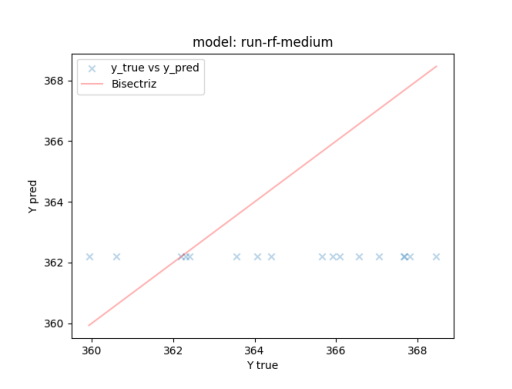

In [33]:
fig_ytrue_ypred